# L2: Text classification

Text classification is the task of sorting text documents into predefined classes. The concrete problem you will be working on in this lab is the classification of texts with respect to their political affiliation. The specific texts you are going to classify are speeches held in the [Riksdag](https://www.riksdagen.se/en/), the Swedish national legislature.

## Data set

The raw data for this lab comes from [The Riksdag’s Open Data](https://data.riksdagen.se/in-english/). We have tokenized the speeches and put them into two compressed [JSON](https://en.wikipedia.org/wiki/JSON) files:

* `speeches-201718.json.bz2` (speeches from the 2017/2018 parliamentary session)
* `speeches-201819.json.bz2` (ditto, from the 2018/2019 session)

We start by loading these files into two separate data frames.

In [1]:
import pandas as pd
import numpy as np
import zipfile
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
#import bz2

# Loading data to a pandas dataframe
with zipfile.ZipFile('data/spotify_songs.csv.zip') as zip:
    with zip.open('spotify_songs.csv') as myZip:
        df = pd.read_csv(myZip) 

When you inspect the two data frames, you can see that there are three labelled columns: `id` (the official speech ID), `words` (the space-separated words of the speech), and `party` (the party of the speaker, represented by its customary abbreviation).

In [2]:
# Filter English songs
df = df.loc[df['language'] == 'en']

In [3]:
# Data preprocessing

# Filter relevant columns
#df = df[['track_id', 'track_name', 'track_artist', 'lyrics', 'track_album_name', 'playlist_genre']]
df = df[['track_id', 'lyrics', 'playlist_genre']]

# Change column names for model
df = df.rename(columns={'lyrics': 'text', 'playlist_genre': 'label'})

df.head()

track_id                                               text  \
1  004s3t0ONYlzxII9PLgU6z  The trees, are singing in the wind The sky blu...   
2  00chLpzhgVjxs1zKC9UScL  NA Yeah, Spyderman and Freeze in full effect U...   
3  00cqd6ZsSkLZqGMlQCR0Zo  I really can't stay Baby it's cold outside I'v...   
4  00emjlCv9azBN0fzuuyLqy  Get up out of my business You don't keep me fr...   
5  00f9VGHfQhAHMCQ2bSjg3D  Hold your breath, don't look down, keep trying...   

  label  
1  rock  
2   r&b  
3   r&b  
4   pop  
5   r&b

Throughout the lab, we will be using the speeches from 2017/2018 as our training data, and the speeches from 2018/2019 as our test data.

For later reference, we store the sorted list of party abbreviations.

In [4]:
genres = sorted(df['label'].unique())
print(genres)

['edm', 'latin', 'pop', 'r&b', 'rap', 'rock']


## Problem 1: Visualization

Your first task is to get to know the data better by producing a simple visualization.

If you are not familiar with the Swedish political system and the parties represented in the Riksdag in particular, then we suggest that you have a look at the Wikipedia article about the [2018 Swedish general election](https://en.wikipedia.org/wiki/2018_Swedish_general_election).

For the lab, we ask you to compare the two data frames with respect to the distribution of the speeches over the different parties. Write code to generate two bar plots that visualize this information, one for the 2017/2018 speeches and one for the 2018/2019 speeches. Inspect the two plots, and compare them

* to each other
* to the results of the 2014 and the 2018 general elections

Summarize your observations in a short text in the cell below.

**Tip:** If you need help with creating bar plots, [Bar Plot using Pandas](https://dfrieds.com/data-visualizations/bar-plot-python-pandas) provides a useful tutorial.

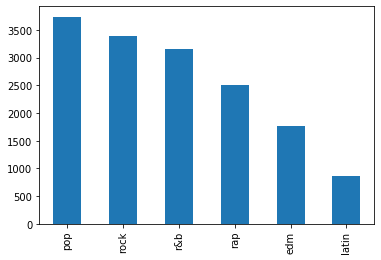

In [5]:
import matplotlib.pyplot as plt

#party_color = ['red', 'deepskyblue', 'green', 'yellow', 'darkred', 'olivedrab', 'slateblue', 'mediumblue']

df['label'].value_counts().plot(kind='bar')
#plt.xlabel("Party", labelpad=14)
#plt.ylabel("Count of Speeches", labelpad=14)
#plt.title("Distribution os Speeches by Party 2017/2018", y=1.02)

In [7]:
# Split train and test
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'])

# Split train and validation
#train_df, validation_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'])
print(df.shape)
print(train_df.shape)
#print(validation_df.shape)
print(test_df.shape)

(15405, 3)
(12324, 3)
(3081, 3)


In [8]:
# Train model
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

/home/oriol/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


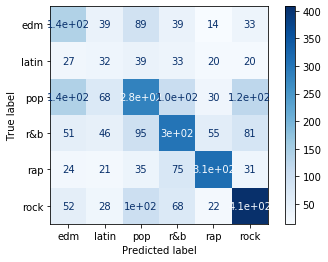

In [13]:
pipe = Pipeline(steps=[('preprocessor', CountVectorizer(stop_words='english')),
                       ('model', LogisticRegression(max_iter=1000,
                                                    class_weight='balanced'))])

fit_pipe = pipe.fit(train_df['text'], train_df['label'])

# TODO: Write code here to solve Problem 5
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from numpy import interp

plot_confusion_matrix(fit_pipe, test_df['text'], test_df['label'], cmap=plt.cm.Blues)

plt.show()

In [17]:
from sklearn.model_selection import GridSearchCV

# Hyperparameters values
parameters = {'preprocessor__binary':[True, False],
              'preprocessor__ngram_range':((1,1),(1,2),(2,2)),
              'model__penalty': ('l2','elasticnet'),
              'model__solver': ('newton-cg', 'saga')}

grid_search = GridSearchCV(pipe, parameters)

gs_fit = grid_search.fit(train_df['text'], train_df['label'])

best_parameters = grid_search.best_estimator_.get_params()

print("Best parameters set:")
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

/home/oriol/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/oriol/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/oriol/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/oriol/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/oriol/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was

Best parameters set:
	model__penalty: 'l2'
	model__solver: 'newton-cg'
	preprocessor__binary: True
	preprocessor__ngram_range: (1, 2)


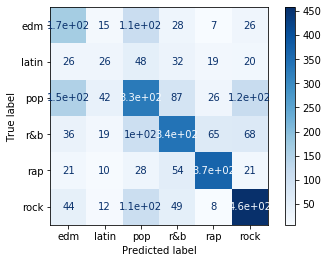

In [19]:
plot_confusion_matrix(gs_fit, test_df['text'], test_df['label'], cmap=plt.cm.Blues)

In [20]:
preds = gs_fit.predict(test_df['text'])

print(classification_report(test_df['label'], preds, zero_division = 0))

              precision    recall  f1-score   support

         edm       0.37      0.47      0.42       352
       latin       0.21      0.15      0.18       171
         pop       0.45      0.44      0.45       748
         r&b       0.58      0.54      0.56       632
         rap       0.75      0.73      0.74       500
        rock       0.65      0.67      0.66       678

    accuracy                           0.55      3081
   macro avg       0.50      0.50      0.50      3081
weighted avg       0.55      0.55      0.54      3081



/home/oriol/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


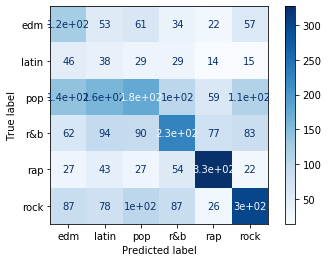

In [32]:
n_min = min(train_df['label'].value_counts())

# Sample n_min observations of each class
balanced = train_df.groupby('label').apply(lambda x: x.sample(n=n_min, replace=False))

pipe = Pipeline(steps=[('preprocessor', CountVectorizer()), ('model', LogisticRegression())])
fit_pipe = pipe.fit(balanced['text'], balanced['label'])

plot_confusion_matrix(fit_pipe, test_df['text'], test_df['label'], cmap=plt.cm.Blues)

plt.show()


## Problem 2: Naive Bayes classifier

You are now ready to train and evaluate a classifier. More specifically, we ask you to train a [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) classifier. You will have to

1. vectorize the speeches in the training data
2. instantiate and fit the Naive Bayes model
3. evaluate the model on the test data

The scikit-learn library provides a convenience class [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that allows you to solve the first two tasks with very compact code. For the evaluation you can use the function [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), which will report per-class precision, recall and F1, as well as overall accuracy.

In [19]:
# TODO: Write code here to train and evaluate a Multinomial Naive Bayes classifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

pipe = Pipeline(steps=[('preprocessor', CountVectorizer()), ('model', MultinomialNB())])
pipe.fit(training_data['words'], training_data['party'])

preds = pipe.predict(test_data['words'])

print(classification_report(test_data['party'], preds, zero_division = 0))

              precision    recall  f1-score   support

           C       0.63      0.04      0.07       671
          KD       0.70      0.02      0.03       821
           L       0.92      0.02      0.04       560
           M       0.36      0.68      0.47      1644
          MP       0.36      0.25      0.29       809
           S       0.46      0.84      0.59      2773
          SD       0.57      0.12      0.20      1060
           V       0.59      0.15      0.24       950

    accuracy                           0.43      9288
   macro avg       0.57      0.26      0.24      9288
weighted avg       0.52      0.43      0.34      9288



Would you have expected the results that you got?

* Yes, as the Naive Bayes classifier assumes strong independencies, the results can improve. In particular, 
* Precision:number of correctly classified over all the observations labeled in a class. The classes with larger number of observations have worst precision as the classifier labels too many observations as those classes.
* Recall: proportion of correctly classified documents among all documents from that class. The "large" classes have a good recall due the fact that the model labels many observations in those classes. The "false positives" are not present. In contrast, the other classes have a very bad recall. 
* f1-score: a balanced score between precision and recall. It is good for samples were classes have very different sizes. It combines both precision and recall.

## Problem 3: Baselines

Evaluation metrics such as accuracy should not be understood as absolute measures of performance, but should be used only to compare different classifiers. When other classifiers are not available, a simple baseline is a classifier that generates predictions by random sampling, respecting the training set&rsquo;s class distribution. This baseline is implemented by the class [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). What is the performance of the random baseline on the test data?

In [20]:
# TODO: Write code here to evaluate the random baseline
from sklearn.dummy import DummyClassifier

pipe = Pipeline(steps=[('preprocessor', CountVectorizer()), ('model', DummyClassifier('stratified'))])
pipe.fit(training_data['words'], training_data['party'])

preds = pipe.predict(test_data['words'])

print(classification_report(test_data['party'], preds, zero_division = 0))

              precision    recall  f1-score   support

           C       0.07      0.07      0.07       671
          KD       0.07      0.05      0.06       821
           L       0.07      0.07      0.07       560
           M       0.17      0.18      0.18      1644
          MP       0.08      0.12      0.10       809
           S       0.31      0.36      0.33      2773
          SD       0.10      0.08      0.09      1060
           V       0.10      0.07      0.08       950

    accuracy                           0.18      9288
   macro avg       0.12      0.12      0.12      9288
weighted avg       0.17      0.18      0.17      9288



An even dumber baseline is to predict, for every document, that class which appears most often in the training data. This baseline is also called the most frequent class baseline. What is the accuracy of that baseline on the test data?

In [21]:
# TODO: Write code here to print the accuracy of the most frequent class baseline
pipe = Pipeline(steps=[('preprocessor', CountVectorizer()), ('model', DummyClassifier('most_frequent'))])
pipe.fit(training_data['words'], training_data['party'])

preds = pipe.predict(test_data['words'])

print(classification_report(test_data['party'], preds, zero_division = 0))

              precision    recall  f1-score   support

           C       0.00      0.00      0.00       671
          KD       0.00      0.00      0.00       821
           L       0.00      0.00      0.00       560
           M       0.00      0.00      0.00      1644
          MP       0.00      0.00      0.00       809
           S       0.30      1.00      0.46      2773
          SD       0.00      0.00      0.00      1060
           V       0.00      0.00      0.00       950

    accuracy                           0.30      9288
   macro avg       0.04      0.12      0.06      9288
weighted avg       0.09      0.30      0.14      9288



## Problem 4: Creating a balanced data set

As you saw in Problem&nbsp;1, the distribution of the speeches over the eight different parties (classes) is imbalanced. One technique used to alleviate this is **undersampling**, in which one randomly removes samples from over-represented classes until all classes are represented with the same number of samples.

Implement undersampling to create a balanced subset of the training data. Rerun the evaluation from Problem&nbsp;2 on the balanced data and compare the results. Discuss your findings in a short text. Would you argue that undersampling make sense for the task of predicting the party of a speaker?

**Hint:** Your balanced subset should consist of 5,752 speeches.

In [10]:
# TODO: Write code here to implement undersampling
# Number of observations of the smallest class
n_min = min(training_data['party'].value_counts())

# Sample n_min observations of each class
balanced = training_data.groupby('party').apply(lambda x: x.sample(n=n_min, replace=False))

print(balanced.shape)

(5752, 3)


In [22]:
pipe = Pipeline(steps=[('preprocessor', CountVectorizer()), ('model', MultinomialNB())])
fit_pipe = pipe.fit(balanced['words'], balanced['party'])

preds = fit_pipe.predict(test_data['words'])

print(classification_report(test_data['party'], preds, zero_division = 0))

              precision    recall  f1-score   support

           C       0.28      0.44      0.34       671
          KD       0.31      0.39      0.34       821
           L       0.26      0.43      0.33       560
           M       0.39      0.51      0.45      1644
          MP       0.35      0.37      0.36       809
           S       0.80      0.27      0.40      2773
          SD       0.44      0.44      0.44      1060
           V       0.39      0.55      0.46       950

    accuracy                           0.40      9288
   macro avg       0.40      0.42      0.39      9288
weighted avg       0.49      0.40      0.40      9288



*TODO: Enter your answer here*

**Answer:**
* Undersampling improves the accuracy of the model as the classes were very imbalanced before, giving the same importance to small and large classes. However, one could say that is better that large classes are more important in the model, as when predicting there will be also more observations of said classes.

## Problem 5: Confusion matrix

A **confusion matrix** is a specific table that is useful when analysing the performance of a classifier. In this table, both the rows and the columns correspond to classes, and each cell $(i, j)$ states how many times a sample with gold-standard class $i$ was predicted as belonging to class $j$.

In scitkit-learn, the confusion matrix of a classifier is computed by the function [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). If you would rather see a visual representation, you can also use [`plot_confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

Your task is to use the confusion matrix in order to find, for each given party $p$ in the Riksdag, that other party $p'$ which the classifier that you trained in Problem&nbsp;4 most often confuses with $p$ when it predicts the party of a speaker.

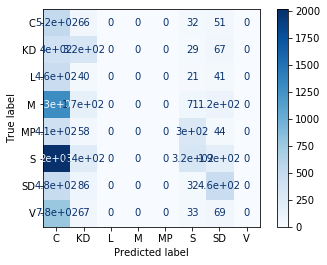

In [23]:
# TODO: Write code here to solve Problem 5
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from numpy import interp

plot_confusion_matrix(fit_pipe, preds, test_data['party'], cmap=plt.cm.Blues)

plt.show()

Take a minute to reflect on the question whether your results make sense.

**Answer:**
* The classifier predicts many observations as class C.

## Problem 6: Grid search

Until now, you have been using the vectorizer and the Naive Bayes classifier with their default hyperparameters. When working with real-world applications, you would want to find settings for the hyperparameters that maximize the performance for the task at hand.

Manually tweaking the hyperparameters of the various components of a vectorizer–classifier pipeline can be cumbersome. However, scikit-learn makes it possible to run an exhaustive search for the best hyperparameters over a grid of possible values. This method is known as **grid search**.

The hyperparameters of a pipeline should never be tuned on the final test set. (Why would that be a bad idea?) Instead, one should either use a separate validation set, or run cross-validation over different folds. Here we will use cross-validation.

Implement a grid search with 5-fold cross-validation to find the optimal parameters in a grid defined by the following choices for the hyperparameters:

* In the vectorizer, try a set-of-words model in addition to the default bag-of-words model (two possible parameter values).
* Also in the vectorizer, try extracting bigrams in addition to unigrams (two possible parameter values).
* In the Naive Bayes classifier, try using additive smoothing with $\alpha \in \{1, 0{.}1\}$ (two possible parameter values).

Use the class [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from the scikit-learn library. Print the results of your best model, along with the parameter values that yielded these results.

In [36]:
# TODO: Write code here to implement the grid search
from sklearn.model_selection import GridSearchCV

# Hyperparameters values
parameters = {'preprocessor__binary':[True, False],
              'preprocessor__ngram_range':((1,1),(2,2)),
              'model__alpha':[1,0.1]}

grid_search = GridSearchCV(pipe, parameters)

gs_fit = grid_search.fit(balanced['words'], balanced['party'])

best_parameters = grid_search.best_estimator_.get_params()

print("Best parameters set:")
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best parameters set:
	model__alpha: 0.1
	preprocessor__ngram_range: (2, 2)


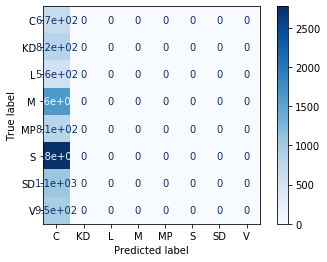

In [37]:
preds = gs_fit.predict(test_data['words'])
plot_confusion_matrix(gs_fit, preds, test_data['party'], cmap=plt.cm.Blues)
plt.show()

## Problem 7: Try to improve your results

Scikit-learn makes it easy to test different vectorizer–classifier pipelines – among other things, it includes different types of logistic regression classifiers, support vector machines, and decision trees. Browse the library to see which methods are supported.

Build a pipeline that you find interesting, and use grid search to find optimal settings for the hyperparameters. Print the results of your best model. Did you manage to get better results than the ones that you obtained in Problem&nbsp;6? Answer with a short text.

In [39]:
# TODO: Write code here to search for a better model
from sklearn.linear_model import SGDClassifier

pipe = Pipeline(steps=[('vect', CountVectorizer()), ('model', SGDClassifier())])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2), (2,2)),  # unigrams or bigrams
    'model__max_iter': (10, 50, 80),
    'model__alpha': (0.00001, 0.000001),
    'model__penalty': ('l2', 'elasticnet'),
}

grid_search = GridSearchCV(pipe, parameters)

best_fit = grid_search.fit(balanced['words'], balanced['party'])

best_parameters = grid_search.best_estimator_.get_params()

print("Best parameters set:")
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

/home/oriol/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Best parameters set:
	model__alpha: 1e-06
	model__max_iter: 50
	model__penalty: 'elasticnet'
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)


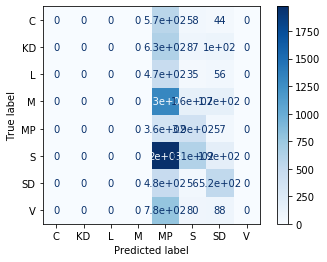

In [40]:
preds = best_fit.predict(test_data['words'])
plot_confusion_matrix(best_fit, preds, test_data['party'], cmap=plt.cm.Blues)
plt.show()

*TODO: Enter your answer here*

**Answer**:
* The classifier using Support Vector Machines and Stochastic Gradient Descent manages to label observations as being part of 3 classes instead of only 1. The previous classifier labelled all the observations as being part of the class C. Therefore the model is better. However, with this new model, there are still classes that are not well represented. 

<div class="alert alert-info">
    Please read the section ‘General information’ on the ‘Labs’ page of the course website before submitting this notebook!
</div>